In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D
from function.water_data import Water

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# Water 클래스 인스턴스 생성
wa = Water()

In [5]:
# 수질 데이터 로드
waterDF = wa.api_data()
waterDF.columns

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  ...  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a
0    물금 2021-01-04  4.6         7.5  ...    0.025         3.8  29.555    12.4
1    물금 2021-01-11  2.8         7.3  ...    0.031         4.0  28.599    19.4
2    물금 2021-01-26  5.1         7.2  ...    0.026         4.6  74.897    47.3
3    물금 2021-01-18  3.1         7.3  ...    0.032         4.4  47.190    33.2
4    물금 2021-02-16  6.6         8.4  ...    0.027         5.0  72.735    50.4

[5 rows x 14 columns]


Index(['총량지점명', '일자', '수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD',
       'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량', '클로로필-a'],
      dtype='object')

In [ ]:
waterDF.describe().T

In [6]:
# 물금과 금곡 지점 데이터 분리
mulgeum_df = waterDF[waterDF['총량지점명'] == '물금'].copy().set_index('일자').dropna()
geumgok_df = waterDF[waterDF['총량지점명'] == '금곡'].copy().set_index('일자').dropna()

물금 유량 대비 금곡 유량이 일정 비율 이하로 떨어질 때, 즉 두 지점 사이의 체류시간이 일정 이상일때 클로로필a농도가 상승할 것이다. 귀무 가설

결론, 두 지점 사이의 유량 차이를 일정 이상 유지하는게 좋을 수 도 있다.


In [ ]:
# 유량 차이 및 증폭도 분석
c_df = pd.DataFrame()
c_df['유량차이'] = geumgok_df['유량'] - mulgeum_df['유량']
c_df['물금'] = mulgeum_df['클로로필-a']
c_df['금곡'] = geumgok_df['클로로필-a']
c_df['증폭도'] = geumgok_df['클로로필-a'] / mulgeum_df['클로로필-a']
c_df.dropna(inplace=True)
c_df.describe()

In [ ]:
def draw_3d_algae_plot(df, title):
    """3D 수질 분석 그래프 그리기"""
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 데이터 준비
    x = mdates.date2num(df.index)
    y = df['유량']
    z = df['클로로필-a']
    
    # 3D 산점도 그리기
    scatter = ax.scatter(x, y, z, c=z, cmap='viridis', s=50, alpha=0.6)
    
    # 축 설정
    ax.set_title(f'{title} 3D 수질 분석 (일자-유량-Chl-a)')
    ax.set_xlabel('날짜')
    ax.set_ylabel('유량 (m³/s)')
    ax.set_zlabel('클로로필-a (mg/m³)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # 컬러바 추가
    fig.colorbar(scatter, ax=ax, label='클로로필-a 농도', shrink=0.5)
    plt.show()

# 물금과 금곡 3D 시각화
draw_3d_algae_plot(mulgeum_df, "물금")
draw_3d_algae_plot(geumgok_df, "금곡")


,유량차이,물금,금곡,증폭도
count,177.000000,177.000000,177.000000,177.000000
mean,5.280836,22.651977,21.255932,1.065813
std,23.562030,17.097960,15.439901,0.534889
min,0.000000,1.100000,1.700000,0.279570
25%,0.570000,9.100000,9.300000,0.734082
50%,1.041000,17.900000,18.800000,0.960000
75%,3.312000,33.200000,28.000000,1.277778
max,222.636000,95.500000,72.800000,4.057692


In [8]:
# 하굿둑 데이터 로드
damDF = wa.dam()

하굿둑 데이터 확보 성공: 240건


In [9]:
def aggregate_monthly_data(water_df, dam_df):
    """수질 데이터와 하굿둑 데이터를 월별로 집계하고 병합"""
    # 날짜 컬럼을 datetime 형식으로 변환
    water_df = water_df.copy()
    water_df['일자'] = pd.to_datetime(water_df.index)
    dam_df = dam_df.copy()
    dam_df['일자'] = pd.to_datetime(dam_df['일자'])
    
    # 수질 데이터: 연월별 평균 구하기
    water_columns = {
        '수온': 'mean',
        '클로로필-a': 'mean',
        '유량': 'mean',
        '총유기탄소(TOC)': 'mean',
        '총인(T-P)': 'mean',
        '부유물질': 'mean'
    }
    water_monthly = water_df.groupby(water_df['일자'].dt.to_period('M')).agg(water_columns).reset_index()
    
    # 하굿둑 데이터: 연월별 총합 구하기
    dam_columns = {
        '하굿둑방류량': 'sum',
        '하굿둑강수량': 'sum'
    }
    dam_monthly = dam_df.groupby(dam_df['일자'].dt.to_period('M')).agg(dam_columns).reset_index()
    
    # 두 데이터 병합
    result = pd.merge(water_monthly, dam_monthly, on='일자', how='inner')
    result['일자'] = result['일자'].dt.to_timestamp()
    result.dropna(inplace=True)
    
    return result

# 물금 지점 월별 데이터 집계
mulgeum_df = aggregate_monthly_data(mulgeum_df, damDF)
mulgeum_df

,일자,수온,클로로필-a,유량,총유기탄소(TOC),총인(T-P),부유물질,하굿둑방류량,하굿둑강수량
0,2021-01-01,3.900000,28.075000,45.060250,4.200000,0.028500,5.100,222.9,11.4
1,2021-02-01,5.875000,47.025000,35.312250,4.675000,0.030750,8.500,145.8,17.7
2,2021-03-01,11.050000,40.700000,251.268250,4.600000,0.094000,9.200,561.9,103.3
3,2021-04-01,16.975000,21.525000,243.602000,3.825000,0.037000,5.500,729.4,51.7
4,2021-05-01,20.025000,8.825000,291.149000,3.300000,0.033000,3.000,621.3,110.3
5,2021-06-01,25.900000,30.050000,246.631250,4.450000,0.025000,5.500,592.2,64.5
6,2021-07-01,28.000000,18.300000,1382.219000,4.850000,0.072250,27.200,2534.6,252.1
7,2021-08-01,28.650000,29.650000,1243.763250,4.425000,0.057750,30.600,2391.6,284.2
8,2021-09-01,23.925000,29.325000,327.825000,4.800000,0.052500,10.500,1393.0,120.7
9,2021-10-01,22.775000,48.900000,216.066250,4.450000,0.024000,8.900,477.7,45.5


In [ ]:
# 금곡 지점 월별 데이터 집계
geumgok_df = aggregate_monthly_data(geumgok_df, damDF)
geumgok_df

,일자,수온,클로로필-a,유량,총유기탄소(TOC),총인(T-P),부유물질,하굿둑방류량,하굿둑강수량
0,2021-01-01,3.900000,28.075000,45.060250,4.200000,0.028500,5.100,222.9,11.4
1,2021-02-01,5.875000,47.025000,35.312250,4.675000,0.030750,8.500,145.8,17.7
2,2021-03-01,11.050000,40.700000,251.268250,4.600000,0.094000,9.200,561.9,103.3
3,2021-04-01,16.975000,21.525000,243.602000,3.825000,0.037000,5.500,729.4,51.7
4,2021-05-01,20.025000,8.825000,291.149000,3.300000,0.033000,3.000,621.3,110.3
5,2021-06-01,25.900000,30.050000,246.631250,4.450000,0.025000,5.500,592.2,64.5
6,2021-07-01,28.000000,18.300000,1382.219000,4.850000,0.072250,27.200,2534.6,252.1
7,2021-08-01,28.650000,29.650000,1243.763250,4.425000,0.057750,30.600,2391.6,284.2
8,2021-09-01,23.925000,29.325000,327.825000,4.800000,0.052500,10.500,1393.0,120.7
9,2021-10-01,22.775000,48.900000,216.066250,4.450000,0.024000,8.900,477.7,45.5


In [ ]:
def plot_precipitation_vs_suspended_solids(mulgeum_data, geumgok_data):
    """강수량 대비 부유물질(SS) 시각화"""
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    # Y축 범위 설정 (두 지점 중 최대값 기준)
    max_ss = max(mulgeum_data['부유물질'].max(), geumgok_data['부유물질'].max()) * 1.1
    
    # 물금 지점 (상단)
    sb.regplot(data=mulgeum_data, x='하굿둑강수량', y='부유물질', 
               scatter_kws={'s': 50, 'alpha': 0.5}, line_kws={'color': 'red'}, ax=axes[0])
    
    top3_m = mulgeum_data.nlargest(3, '부유물질')
    axes[0].scatter(top3_m['하굿둑강수량'], top3_m['부유물질'], 
                   color='darkred', s=100, edgecolors='black', zorder=5, label='SS TOP 3')
    
    for _, row in top3_m.iterrows():
        axes[0].annotate(row['일자'].strftime('%Y-%m'), 
                        (row['하굿둑강수량'], row['부유물질']),
                        textcoords="offset points", xytext=(0, 10), 
                        ha='center', fontsize=9, fontweight='bold')
    
    axes[0].set_title('물금 지점: 강수량 대비 부유물질(SS) 민감도', fontsize=14)
    axes[0].set_ylim(0, max_ss)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('SS (mg/L)')
    axes[0].legend()
    
    # 금곡 지점 (하단)
    sb.regplot(data=geumgok_data, x='하굿둑강수량', y='부유물질',
               scatter_kws={'s': 50, 'alpha': 0.5}, line_kws={'color': 'blue'}, ax=axes[1])
    
    top3_g = geumgok_data.nlargest(3, '부유물질')
    axes[1].scatter(top3_g['하굿둑강수량'], top3_g['부유물질'],
                   color='darkblue', s=100, edgecolors='black', zorder=5, label='SS TOP 3')
    
    for _, row in top3_g.iterrows():
        axes[1].annotate(row['일자'].strftime('%Y-%m'),
                        (row['하굿둑강수량'], row['부유물질']),
                        textcoords="offset points", xytext=(0, 10),
                        ha='center', fontsize=9, fontweight='bold')
    
    axes[1].set_title('금곡 지점: 강수량 대비 부유물질(SS) 민감도', fontsize=14)
    axes[1].set_ylim(0, max_ss)
    axes[1].set_xlabel('월간 총 강수량 (mm)')
    axes[1].set_ylabel('SS (mg/L)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_precipitation_vs_suspended_solids(mulgeum_df, geumgok_df)

,일자,수온,클로로필-a,유량,총유기탄소(TOC),총인(T-P),부유물질,하굿둑방류량,하굿둑강수량
0,2021-01-01,4.100000,37.550000,61.990000,4.450000,0.026500,6.400000,222.9,11.4
1,2021-02-01,6.166667,54.500000,42.000000,5.000000,0.029000,10.400000,145.8,17.7
2,2021-03-01,10.625000,35.350000,254.467500,4.525000,0.034000,9.400000,561.9,103.3
3,2021-04-01,16.650000,11.850000,244.397500,3.725000,0.036500,5.500000,729.4,51.7
4,2021-05-01,19.775000,8.375000,293.107500,3.350000,0.032750,3.100000,621.3,110.3
5,2021-06-01,25.150000,23.875000,248.152500,3.975000,0.022750,5.200000,592.2,64.5
6,2021-07-01,26.933333,13.566667,1837.550000,4.633333,0.073333,21.200000,2534.6,252.1
7,2021-08-01,25.950000,24.950000,2132.360000,4.050000,0.074000,20.800000,2391.6,284.2
8,2021-09-01,23.433333,17.566667,322.870000,4.566667,0.060667,11.600000,1393.0,120.7
9,2021-10-01,22.475000,48.675000,218.147500,4.375000,0.022250,9.100000,477.7,45.5


강수량 VS 부유물질

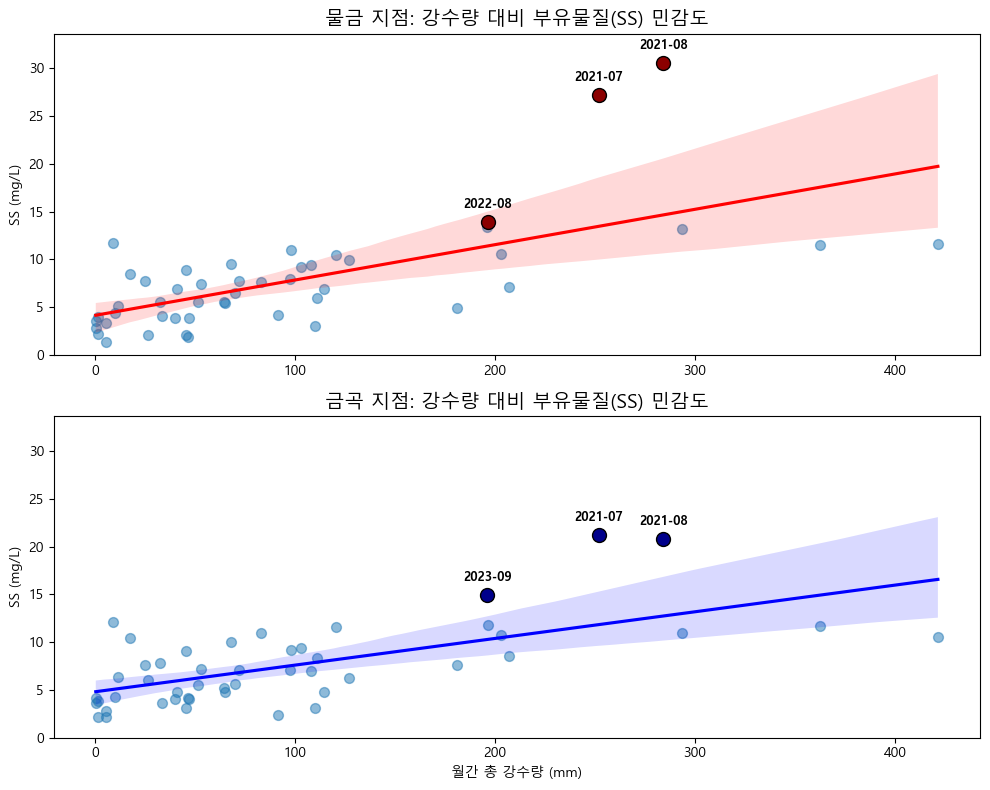

In [ ]:
# 상관관계 분석
correlation_columns = ['부유물질', '총인(T-P)', '클로로필-a']

print('물금')
mulgeum_corr = mulgeum_df[correlation_columns].corr()
print(mulgeum_corr, '\n')

print('금곡')
geumgok_corr = geumgok_df[correlation_columns].corr()
print(geumgok_corr)


월간 오염 부하량

녹조가 적어지기 위해서 어떤쪽을 좀 더 집중해서 보안해야 할까?
귀무가설: 녹조가 적어지기 위해서는 비점오염에 대해서 대비하는게 좀 더 효율적이다.

1. 오염원의 정체: "비점오염(빗물 유출)"

결론: 상관계수가 0.58이라는 것은 물속의 인(T-P) 중 절반 이상이 흙탕물(SS)에 달라붙어 함께 유입

인사이트: 하수처리장에서 나오는 물(점오염)은 대개 맑기 때문에 SS가 낮고 T-P만 높습니다. 

반면, 논·밭이나 도로에서 씻겨 내려오는 빗물은 SS와 T-P가 동시에 높습니다.

결론: 부산 취수원(물금/금곡)의 인 농도를 결정하는 핵심 요인은 하수처리장보다는 **"비가 올 때 상류 지표면에서 씻겨 내려오는 토사와 가축 분뇨"**임을 데이터가 증명하고 있습니다.

2021년 7월 8월은 기온이 높고 강수량이 적음, 무더위가 심해서 장마의 시작이 미루졌음